In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json
import seaborn as sns
import matplotlib.pyplot as plt
import dgl
import sys

# Hetionet Enrichment

In [5]:
drugbank = pd.read_csv("resources/drugbank.tsv", delimiter="\t", header=None)

In [6]:
hetionet_entities = pd.read_csv("resources/hetionet_nodes.tsv", delimiter="\t")
hetionet_compounds = hetionet_entities[hetionet_entities["kind"] == "Compound"]
hetionet_genes = hetionet_entities[hetionet_entities["kind"] == "Gene"]

In [7]:
drugbank_atc = drugbank[drugbank[1] == "DRUGBANK::x-atc::Compound:Atc"]
drugbank_atc_for_hetionet = drugbank_atc[drugbank_atc[0].isin(hetionet_compounds["id"])]

drugbank_compounds_carrier_genes = drugbank[drugbank[1] == "DRUGBANK::carrier::Compound:Gene"]
drugbank_compounds_carrier_genes_for_hetionet = drugbank_compounds_carrier_genes[
    drugbank_compounds_carrier_genes[0].isin(hetionet_compounds["id"])
    & drugbank_compounds_carrier_genes[2].isin(hetionet_genes["id"])
]

drugbank_compounds_enzyme_genes = drugbank[drugbank[1] == "DRUGBANK::enzyme::Compound:Gene"]
drugbank_compounds_enzyme_genes_for_hetionet = drugbank_compounds_enzyme_genes[
    drugbank_compounds_enzyme_genes[0].isin(hetionet_compounds["id"])
    & drugbank_compounds_enzyme_genes[2].isin(hetionet_genes["id"])
]

drugbank_compounds_target_genes = drugbank[drugbank[1] == "DRUGBANK::target::Compound:Gene"]
drugbank_compounds_target_genes_for_hetionet = drugbank_compounds_target_genes[
    drugbank_compounds_target_genes[0].isin(hetionet_compounds["id"])
    & drugbank_compounds_target_genes[2].isin(hetionet_genes["id"])
]

In [23]:
paths = ["datasets/graph.txt", "resources/hetionet_4+1.txt"]

for path in paths:
    with open(path, "a") as file:
        for index, row in drugbank_atc_for_hetionet.iterrows():
            file.write("\t".join([row[0], "CbA", row[2]]) + "\n")

    with open(path, "a") as file:
        for index, row in drugbank_compounds_carrier_genes_for_hetionet.iterrows():
            file.write("\t".join([row[0], "CcG", row[2]]) + "\n")

    with open(path, "a") as file:
        for index, row in drugbank_compounds_enzyme_genes_for_hetionet.iterrows():
            file.write("\t".join([row[0], "CeG", row[2]]) + "\n")

    with open(path, "a") as file:
        for index, row in drugbank_compounds_target_genes_for_hetionet.iterrows():
            file.write("\t".join([row[0], "CtG", row[2]]) + "\n")

In [23]:
pharmacokinetics_ddi = pd.read_csv("resources/pharmacokinetics_ddi.tsv", delimiter="\t")

In [29]:
pharmacokinetics_ddi["ID2"].unique().shape

(656,)

In [20]:
drug_frequency = pharmacokinetics_ddi["ID1"].value_counts()
single_occurrences_data = pharmacokinetics_ddi[pharmacokinetics_ddi["ID1"].isin(drug_frequency[drug_frequency == 1].index)]
multiple_occurrences_data = pharmacokinetics_ddi[pharmacokinetics_ddi["ID1"].isin(drug_frequency[drug_frequency > 1].index)]

train, test = train_test_split(multiple_occurrences_data, test_size=0.3, stratify=multiple_occurrences_data["ID1"])

drug_frequency = test["ID1"].value_counts()
single_test = test[test["ID1"].isin(drug_frequency[drug_frequency == 1].index)]
multiple_test = test[test["ID1"].isin(drug_frequency[drug_frequency > 1].index)]

test, val = train_test_split(multiple_test, test_size=0.3, stratify=multiple_test["ID1"])

train = pd.concat([train, single_occurrences_data, single_test])
print("Train: ", train.shape)
print("Test: ", test.shape)
print("Val: ", val.shape)

Train:  (22705, 3)
Test:  (6694, 3)
Val:  (2869, 3)


In [24]:
with open("datasets/graph.txt", "a") as file:
    for _, row in train.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")

with open("datasets/train.txt", "w") as file:
    for _, row in train.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")

with open("datasets/test.txt", "w") as file:
    for _, row in test.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")

with open("datasets/dev.txt", "w") as file:
    for _, row in val.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")

In [25]:
with open("resources/hetionet_4+1.txt", "a") as file:
    for _, row in train.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")
    for _, row in test.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")
    for _, row in val.iterrows():
        file.write("\t".join([row["ID1"], "CiC", row["ID2"]]) + "\n")

In [26]:
hetionet_graph = pd.read_csv("datasets/graph.txt", delimiter="\t", header=None)

with open("datasets/graph.txt", "a") as file:
    for _, rows in hetionet_graph.iterrows():
        file.write("\t".join([rows[2], "_" + rows[1], rows[0]]) + "\n")

In [9]:
hetionet_entity_vocab = json.load(open("hetionet_4+1/vocab/entity_vocab.json"))
hetionet_relation_vocab = json.load(open("hetionet_4+1/vocab/relation_vocab.json"))

In [ ]:
drugbank_entity_emb = np.load('../drugbank/embed/drugbank_TransE_l2_entity.npy')
drugbank_relation_emb = np.load('../drugbank/embed/drugbank_TransE_l2_relation.npy')

In [ ]:
drugbank_entities = pd.read_csv("../drugbank/embed/entities.tsv", delimiter="\t", header=None)
drugbank_relations = pd.read_csv("../drugbank/embed/relations.tsv", delimiter="\t", header=None)

In [ ]:
drugbank_entities_for_hetionet = drugbank_entities[drugbank_entities[0].isin(hetionet_entity_vocab.keys())]
drugbank_entities_for_hetionet

,0,1
0,Gene::2157,0
1,Gene::5264,1
2,Gene::2158,2
3,Gene::3309,3
5,Gene::811,5
...,...,...
96855,Gene::401027,96855
96856,Gene::255349,96856
96857,Gene::347541,96857
96858,Gene::4114,96858


In [ ]:
drugbank_entity_emb_for_hetionet = drugbank_entity_emb[drugbank_entities_for_hetionet[1]]
drugbank_entity_emb_for_hetionet.shape

(47242, 400)

In [ ]:
entity_to_id = {}

drugbank_entities_for_hetionet = drugbank_entities_for_hetionet.reset_index()
for i, row in drugbank_entities_for_hetionet.iterrows():
    entity_to_id[row[0]] = i

with open("hetionet_4+1/embed/entity_to_id.json", "w") as file:
    json.dump(entity_to_id, file)


In [ ]:
np.save("hetionet_4+1/embed/entity_embeddings.npy", drugbank_entity_emb_for_hetionet)

In [ ]:
drugbank_relations.loc[drugbank_relations[0] == "DRUGBANK::x-atc::Compound:Atc", 0] = "::CbA"
drugbank_relations.loc[drugbank_relations[0] == "DRUGBANK::enzyme::Compound:Gene", 0] = "::CeG"
drugbank_relations.loc[drugbank_relations[0] == "DRUGBANK::carrier::Compound:Gene", 0] = "::CcG"
drugbank_relations.loc[drugbank_relations[0] == "DRUGBANK::target::Compound:Gene", 0] = "::CtG"
drugbank_relations.loc[drugbank_relations[0] == "DRUGBANK::ddi-interactor-in::Compound:Compound", 0] = "::CiC"


In [ ]:
drugbank_relations[2] = drugbank_relations[0].str.split(":", expand=True)[2]
drugbank_relations_for_hetionet = drugbank_relations[drugbank_relations[2].isin(hetionet_relation_vocab.keys())][2]
drugbank_relations_for_hetionet

19     CbA
20     CiC
21     CtG
22     CeG
23     CcG
62    GpBP
63     GiG
64     CrC
65     DdG
66     DpS
67     DlA
68     CtD
69     CbG
70     CuG
71     DrD
72     DaG
73     CpD
74     AdG
75     AuG
76     GcG
77    GpMF
78    PCiC
79    GpCC
80    Gr>G
81     CdG
82     DuG
83    GpPW
84    CcSE
85     AeG
Name: 2, dtype: object

In [ ]:
drugbank_relation_emb_for_hetionet = drugbank_relation_emb[drugbank_relations_for_hetionet.index]
drugbank_relation_emb_for_hetionet.shape

(29, 400)

In [ ]:
drugbank_relation_emb_for_hetionet = np.concatenate([drugbank_relation_emb_for_hetionet, -drugbank_relation_emb_for_hetionet], axis=0)
drugbank_relation_emb_for_hetionet.shape

(58, 400)

In [ ]:
np.save("hetionet_4+1/embed/relation_embeddings.npy", drugbank_relation_emb_for_hetionet)

In [ ]:
relation_to_id = {}

drugbank_relations_for_hetionet = drugbank_relations_for_hetionet.reset_index()
for i, row in drugbank_relations_for_hetionet.iterrows():
    relation_to_id[row[2]] = i

for i, row in drugbank_relations_for_hetionet.iterrows():
    relation_to_id["_" + row[2]] = i + len(drugbank_relations_for_hetionet)

with open("hetionet_4+1/embed/relation_to_id.json", "w") as file:
    json.dump(relation_to_id, file)

# Hetionet Statistics

In [2]:
hetionet = pd.read_csv("resources/hetionet_4+1.txt", sep="\t", header=None) 
triplets = hetionet.values.tolist()

In [127]:
entity_dictionary = {}


def insert_entry(entry, ent_type, dic):
    if ent_type not in dic:
        dic[ent_type] = {}
    ent_n_id = len(dic[ent_type])
    if entry not in dic[ent_type]:
        dic[ent_type][entry] = ent_n_id
    return dic


for triple in triplets:
    src = triple[0]
    split_src = src.split("::")
    src_type = split_src[0]
    dest = triple[2]
    split_dest = dest.split("::")
    dest_type = split_dest[0]
    insert_entry(src, src_type, entity_dictionary)
    insert_entry(dest, dest_type, entity_dictionary)

prev_k_len = 0
for k, v in entity_dictionary.items():
    for k2, v2 in v.items():
        entity_dictionary[k][k2] += prev_k_len
    prev_k_len += len(v)

In [128]:
edge_dictionary = {}
node_dictionary = {}
for triple in triplets:
    src = triple[0]
    split_src = src.split("::")
    src_type = split_src[0]
    dest = triple[2]
    split_dest = dest.split("::")
    dest_type = split_dest[0]

    src_int_id = entity_dictionary[src_type][src]
    dest_int_id = entity_dictionary[dest_type][dest]

    pair = [(src_int_id, dest_int_id)]
    etype = triple[1]
    if etype in edge_dictionary:
        edge_dictionary[etype] += pair
    else:
        edge_dictionary[etype] = pair
    if etype in node_dictionary:
        node_dictionary[etype].add(src_int_id)
        node_dictionary[etype].add(dest_int_id)
    else:
        node_dictionary[etype] = set()
        node_dictionary[etype].add(src_int_id)
        node_dictionary[etype].add(dest_int_id)

In [129]:
jacard_pair_info = [
    "edge_type_1\tedge_type_2\tJancard-edge\tJancard-node\tPct of edges included in smaller set\n"
]
keys = list(edge_dictionary.keys())
for i in range(len(keys)):
    for k in range(i + 1, len(keys)):
        e1 = keys[i]
        e2 = keys[k]
        e1_ed = set(edge_dictionary[e1])
        e2_ed = set(edge_dictionary[e2])
        common_edges = e1_ed.intersection(e2_ed)
        union_edges = e1_ed.union(e2_ed)
        jacard_edge = float(len(common_edges) / (len(union_edges)))

        n1_d = node_dictionary[e1]
        n2_d = node_dictionary[e2]
        common_nodes = n1_d.intersection(n2_d)
        union_nodes = n1_d.union(n2_d)
        jacard_node = float(len(common_nodes) / (len(union_nodes)))

        if len(e1_ed) > len(e2_ed):
            max_ed = e1_ed
            min_ed = e2_ed
        else:
            max_ed = e2_ed
            min_ed = e1_ed
        edge_inclusion = float(
            (len(min_ed) - len(min_ed.difference(max_ed))) / len(min_ed)
        )

        jacard_pair_info.append(
            "{}\t{}\t{}\t{}\t{}\n".format(
                e1, e2, jacard_edge, jacard_node, edge_inclusion
            )
        )

In [125]:
jacard_triplets=[jacard_pair_in.split('\t') for jacard_pair_in in jacard_pair_info]
jacard_triplets=[jacard_triplet[:-1]+[jacard_triplet[-1].split('\n')[0]] for jacard_triplet in jacard_triplets]

In [136]:
import pandas as pd
import numpy as np

# Assuming `jacard_triplets` is already defined
jacard_edge_df = pd.DataFrame(columns = ["CeG", "CtG", "CcG", "CiC"], index = ["CbG", "CdG", "CuG", "CrC"])
jacard_node_df = pd.DataFrame(columns = ["CeG", "CtG", "CcG", "CiC"], index = ["CbG", "CdG", "CuG", "CrC"])

for jacard_triplet in jacard_triplets:
    etype_col = jacard_triplet[1]
    etype_row = jacard_triplet[0]

    if etype_row in jacard_edge_df.columns and etype_col in jacard_edge_df.columns:
        continue

    if etype_col not in jacard_edge_df.columns:
        etype_col, etype_row = etype_row, etype_col

        if etype_col not in jacard_edge_df.columns:
            continue

    if etype_row not in jacard_edge_df.index:
        continue

    jacard_edge_df.loc[etype_row, etype_col] = jacard_triplet[2]
    jacard_node_df.loc[etype_row, etype_col] = jacard_triplet[3]



In [137]:
# Convert the string values to float
jacard_edge_df = jacard_edge_df.astype(float)

# Replace NaN values with 0
jacard_edge_df = jacard_edge_df.fillna(0.0)

# If the value too small, replace it with 0
# jacard_triplets_df = jacard_triplets_df.map(lambda x: 0.0 if x < 0.0000001 else x)

# Sort columns by the number of zeroes
# count_zeroes = (jacard_triplets_df == 0.0).sum() 
# jacard_triplets_df = jacard_triplets_df[count_zeroes.sort_values().index] 

# Sort rows by the number of zeroes
# count_zeroes = (jacard_triplets_df == 0.0).sum(axis=1)
# jacard_triplets_df = jacard_triplets_df.loc[count_zeroes.sort_values().index]

# jacard_edge_df.loc["CbG", "CtG"] = jacard_edge_df.loc["CbG", "CtG"] / 10
# jacard_edge_df.loc["CbG", "CeG"] = jacard_edge_df.loc["CbG", "CeG"] / 10
# jacard_triplets_df.loc["CbG", "CcG"] = jacard_triplets_df.loc["CbG", "CcG"] / 100000

# Apply a log transformation to the values
jacard_edge_df = jacard_edge_df.map(lambda x: -np.log(x) if x != 0.0 else None)
tmp_max = jacard_edge_df.max().max()
jacard_edge_df = jacard_edge_df.fillna(tmp_max)
jacard_edge_df = jacard_edge_df.map(lambda x: tmp_max - x)

jacard_edge_df

,CeG,CtG,CcG,CiC
CbG,8.464576,8.980379,5.986325,0.000000
CdG,0.591087,2.644414,0.000000,0.000000
CuG,0.000000,2.848937,0.000000,0.000000
CrC,0.000000,0.000000,0.000000,3.858944


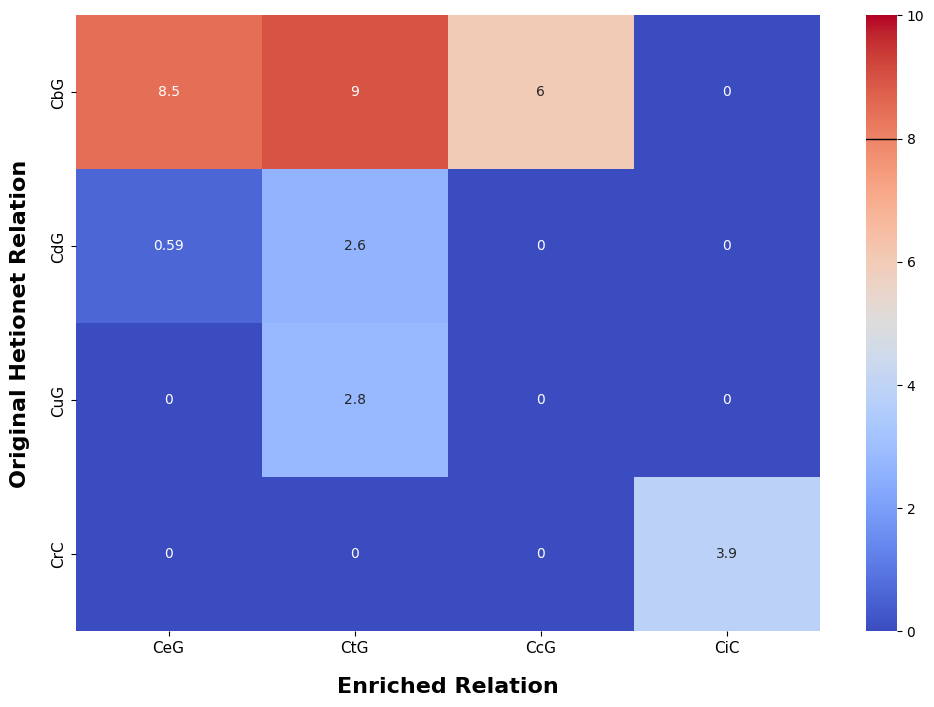

In [112]:
# Find the minimum and maximum values in the DataFrame
vmin = jacard_edge_df.min().min()  # Minimum value
vmin = 0.0
vmax = 10

# Set the figure size before plotting
plt.figure(figsize=(12, 8))

# Plot the heatmap with adjusted min and max values
ax = sns.heatmap(jacard_edge_df, annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax, center=5)

colorbar = ax.collections[0].colorbar
threshold = 8

# Add a line on the colorbar at the threshold
colorbar.ax.axhline(threshold, color='black', linewidth=1)
# colorbar.ax.text(0.5, threshold_norm, f'{threshold}', color='black', fontsize=10, ha='center', va='center')

# Label adjustments
plt.xlabel("Enriched Relation", labelpad=15, fontsize=16, fontweight='bold')
plt.ylabel("Original Hetionet Relation", labelpad=15, fontsize=16, fontweight='bold')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot
plt.show()